
=== Training Prophet Model for Patient_Monitors_Required ===


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [1]:
!pip install prophet


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
df

,Day_Index,Is_Weekend,Total_Admissions_Today,Total_Discharges_Today,ICU_Admissions_Today,Surgeries_Today,Bed_Occupancy_Rate,Patient_Monitors_Required,Defibrillators_Required,Infusion_Pumps_Required
0,0,0,43,24,12,7,0.60,17,8,30
1,1,0,35,28,8,7,0.70,13,6,22
2,2,0,38,12,7,4,0.73,10,4,22
3,3,0,16,33,13,5,0.86,18,8,24
4,4,0,16,30,2,9,0.78,7,4,8
...,...,...,...,...,...,...,...,...,...,...
725,725,0,41,32,14,6,1.00,19,8,32
726,726,1,26,19,4,1,1.00,5,2,13
727,727,1,27,6,4,0,1.00,5,2,13
728,728,0,32,28,13,7,1.00,18,8,28


In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv("equipment_data.csv")

# Convert Data_index (integers) into proper datetime format for Prophet
df["ds"] = pd.date_range(start="2023-01-01", periods=len(df), freq="D")

# Feature engineering with lagged variables
features = [
    "Total_Admissions_Today",
    "Total_Discharges_Today",
    "ICU_Admissions_Today",
    "Surgeries_Today",
    "Bed_Occupancy_Rate",
    "Is_Weekend"
]

targets = ["Patient_Monitors_Required", "Defibrillators_Required", "Infusion_Pumps_Required"]

# Create lagged features (using previous day's values to predict next day's equipment)
for feature in features:
    df[f'{feature}_lag1'] = df[feature].shift(1)

# Drop first row with NaN values
df = df.dropna()

# Define Prophet parameter grid for tuning
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False]
}

# Store best models and parameters
best_models = {}
best_params = {}

for target in targets:
    print(f"\n=== Training Prophet Model for {target} ===")
    
    # Prepare dataset with lagged features
    target_df = df[['ds', target]].copy().rename(columns={target: 'y'})
    for feature in features:
        target_df[feature] = df[f'{feature}_lag1']
    
    # Split data (time-based)
    train_size = int(len(target_df) * 0.8)
    train = target_df.iloc[:train_size]
    test = target_df.iloc[train_size:]
    
    # Hyperparameter tuning
    best_score = float('inf')
    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        
        model = Prophet(**current_params)
        for feature in features:
            model.add_regressor(feature)
            
        model.fit(train)
        
        # Cross-validation
        df_cv = cross_validation(model, horizon='10 days', parallel="processes")
        pm = performance_metrics(df_cv, rolling_window=1)
        score = pm['rmse'].values[0]
        
        if score < best_score:
            best_score = score
            best_params[target] = current_params
            best_model = model
            
    # Train final model with best parameters
    final_model = Prophet(**best_params[target])
    for feature in features:
        final_model.add_regressor(feature)
    final_model.fit(target_df)
    
    # Save model
    model_path = f"prophet_{target}_model.joblib"
    joblib.dump(final_model, model_path)
    best_models[target] = final_model
    
    # Evaluate
    future = final_model.make_future_dataframe(periods=len(test))
    future = future.merge(target_df[features], left_on='ds', right_index=True)
    forecast = final_model.predict(future)
    
    y_true = test['y'].values
    y_pred = forecast.iloc[-len(test):]['yhat'].values
    
    print(f"{target} R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"{target} RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")

# Predict next day's equipment needs
def predict_equipment():
    predictions = {}
    last_known = df.iloc[-1][features].values
    
    # Create future dataframe
    future_date = df["ds"].max() + pd.DateOffset(days=1)
    future_df = pd.DataFrame({'ds': [future_date]})
    
    # Add regressors (using last known values)
    for i, feature in enumerate(features):
        future_df[feature] = last_known[i]
    
    for target in targets:
        model = best_models[target]
        forecast = model.predict(future_df)
        predictions[target] = forecast['yhat'].values[0]
    
    return predictions

# Get predictions
equipment_pred = predict_equipment()
print("\nPredicted Equipment Requirements for Tomorrow:")
for equip, value in equipment_pred.items():
    print(f"{equip}: {value:.2f}")

def update_model(new_data):
    """
    new_data: DataFrame with new daily data including features and targets
    """
    global df
    
    # Convert Data_index to datetime if necessary
    new_data["ds"] = pd.date_range(start=df["ds"].max() + pd.DateOffset(days=1), periods=len(new_data), freq="D")

    # Append new data
    df = pd.concat([df, new_data], ignore_index=True)
    
    # Update lagged features
    for feature in features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    
    # Retrain models with updated data
    for target in targets:
        # Prepare updated dataset
        target_df = df[['ds', target]].copy().rename(columns={target: 'y'})
        for feature in features:
            target_df[feature] = df[f'{feature}_lag1']
        target_df = target_df.dropna()
        
        # Reinitialize and retrain model
        model = Prophet(**best_params[target])
        for feature in features:
            model.add_regressor(feature)
        model.fit(target_df)
        
        # Save updated model
        joblib.dump(model, f"prophet_{target}_model.joblib")
    
    print("Models updated with new data")

# Example usage:
# new_day_data = pd.DataFrame([{...}])  # New data with all features/targets
# update_model(new_day_data)



=== Training Prophet Model for Patient_Monitors_Required ===


19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:34 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:55 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:08 - cmdstanpy - INFO - Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:19:16 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1]

ValueError: You are trying to merge on datetime64[ns] and int64 columns for key 'ds'. If you wish to proceed you should use pd.concat

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(model, target, test):
    """
    Plots the Prophet forecast vs actual values.
    
    Parameters:
        model (Prophet): Trained Prophet model
        target (str): Target variable name
        test (DataFrame): Test set for comparison
    """
    # Generate future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test))
    future = future.merge(test.drop(columns=['y']), left_on='ds', right_index=True, how="left")  # Add regressors
    forecast = model.predict(future)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df[target], label="Actual Data", color='blue', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='red', linestyle="--")
    
    # Confidence interval
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
    
    plt.axvline(x=test['ds'].iloc[0], color="black", linestyle="dashed", label="Train-Test Split")
    
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.title(f"Prophet Forecast vs Actual for {target}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call plotting function for each target variable
for target in targets:
    print(f"plot for {target}:")
    plot_forecast(best_models[target], target, test)



=== Training Patient_Monitors_Required Model ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3732.779, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3632.475, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3430.747, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3730.782, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3427.520, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3425.104, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3569.239, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3426.249, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3416.293, Time=1.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3427.491, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3425.546, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3419.096, Time=1.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3416.285, Time=1.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3426.01

c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

Test R²: 0.7468
Test RMSE: 1.81


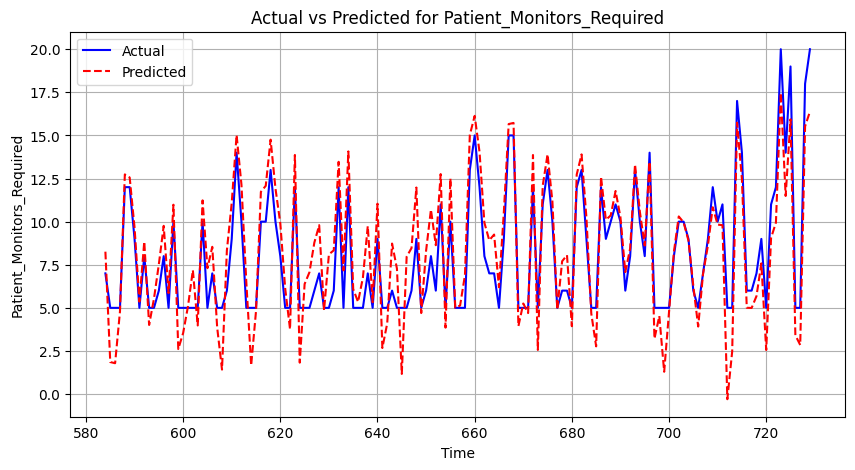


=== Training Defibrillators_Required Model ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2721.120, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2623.423, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2442.916, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2719.127, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2441.063, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2436.599, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2551.990, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2438.207, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2423.442, Time=1.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2440.306, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2437.738, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2431.140, Time=1.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2422.576, Time=1.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2437.421,

c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

Test R²: -0.0894
Test RMSE: 1.35


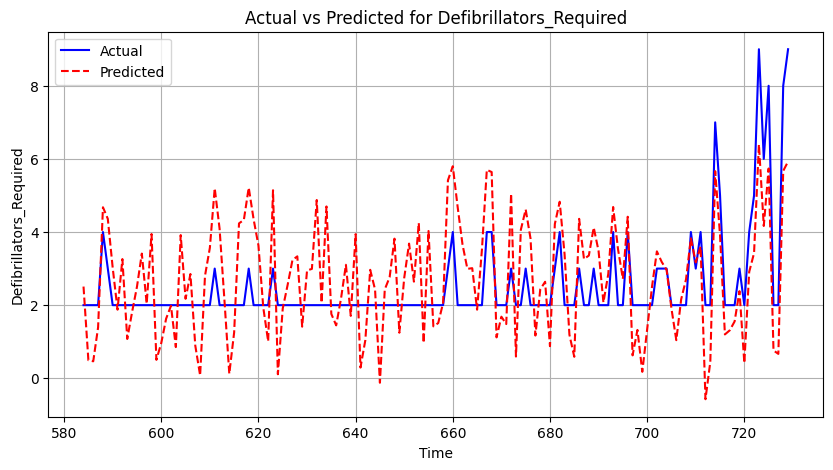


=== Training Infusion_Pumps_Required Model ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4195.456, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4099.067, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3895.538, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4193.456, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3890.285, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3887.923, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4046.374, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3886.773, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4011.951, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3886.575, Time=0.71 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4008.459, Time=0.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3889.725, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3887.874, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3884.725,

c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

Test R²: 0.7453
Test RMSE: 3.21


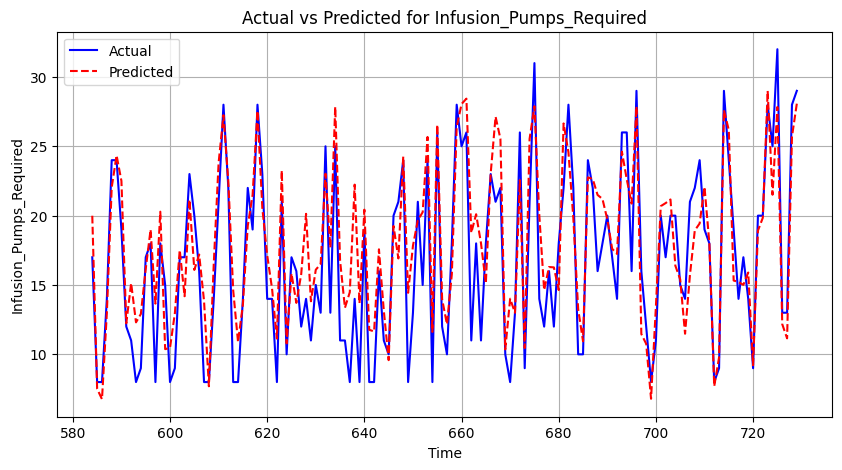

c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is availab


Next Day Equipment Predictions:
Patient_Monitors_Required: 16.40
Defibrillators_Required: 5.98
Infusion_Pumps_Required: 27.56


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import joblib

# Load dataset
df = pd.read_csv("equipment_data.csv")

# Convert data to numeric where applicable
df = df.apply(pd.to_numeric, errors='coerce')

# Add Lag Features (using past 3 days)
lag_days = 3
for col in ["Total_Discharges_Today", "ICU_Admissions_Today", "Surgeries_Today", "Bed_Occupancy_Rate"]:
    for lag in range(1, lag_days + 1):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Drop rows with NaN due to lagging
df.dropna(inplace=True)

features = [
    'Total_Discharges_Today', 'ICU_Admissions_Today', 'Surgeries_Today', 'Bed_Occupancy_Rate'
] + [f"{col}_lag{lag}" for col in [
    "Total_Discharges_Today", "ICU_Admissions_Today", "Surgeries_Today", "Bed_Occupancy_Rate"
] for lag in range(1, lag_days + 1)]

targets = ["Patient_Monitors_Required", "Defibrillators_Required", "Infusion_Pumps_Required"]

# Hyperparameter tuning for ARIMA
def optimize_arima(y, exog):
    return auto_arima(
        y, exogenous=exog,
        start_p=0, start_q=0,
        max_p=4, max_q=4, d=None, max_d=2,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=True,
        information_criterion='aic'
    )

models = {}
for target in targets:
    print(f"\n=== Training {target} Model ===")
    
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    best_model = optimize_arima(train[target], train[features])
    print(f"Best ARIMA{best_model.order} for {target}")
    
    model = SARIMAX(
        endog=train[target],
        exog=train[features],
        order=best_model.order,
        seasonal_order=(0, 0, 0, 0)
    )
    fitted_model = model.fit(disp=False)
    
    # Save model
    model_path = f"arima_{target.replace(' ', '_')}.pkl"
    joblib.dump(fitted_model, model_path)
    models[target] = model_path
    
    # Evaluate
    forecast = fitted_model.get_forecast(steps=len(test), exog=test[features])
    predicted = forecast.predicted_mean
    actual = test[target]
    
    r2 = r2_score(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    
    print(f"Test R²: {r2:.4f}")
    print(f"Test RMSE: {rmse:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, actual, label="Actual", color='blue')
    plt.plot(test.index, predicted, label="Predicted", color='red', linestyle='dashed')
    plt.title(f"Actual vs Predicted for {target}")
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.legend()
    plt.grid()
    plt.show()

# Prediction function
def predict_equipment_requirements(models, latest_data):
    predictions = {}
    for target, path in models.items():
        model = joblib.load(path)
        exog_df = latest_data[features]
        forecast = model.get_forecast(steps=1, exog=exog_df)
        predictions[target] = forecast.predicted_mean.iloc[0]
    return predictions

# Get latest data
latest_data = df.iloc[[-1]]  

# Predict
predictions = predict_equipment_requirements(models, latest_data)

# Print results
print("\nNext Day Equipment Predictions:")
for equip, value in predictions.items():
    print(f"{equip}: {value:.2f}")